## **Import libraries, download and transform CIFAR10 dataset**

100%|██████████| 170498071/170498071 [00:05<00:00, 28957227.52it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
torch.Size([3, 32, 32])
6


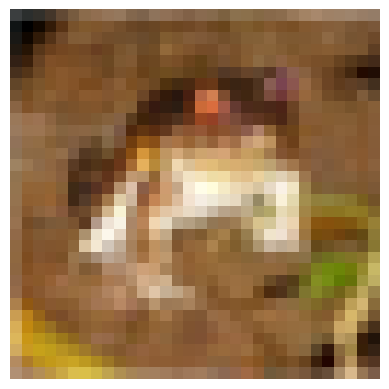

In [ ]:
import torch
import time
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data import DataLoader, Subset

train_dataset = dsets.CIFAR10(root='./data',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.CIFAR10(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

img, label = train_dataset[0]
print(img.shape)
print(label)

plt.figure()
plt.axis("off")
plt.imshow(img.permute(1, 2, 0))

In [ ]:
batch_size = 128
n_iters = 10
num_epochs = 50

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

## **Classification using VGG11 convolutional neural network**

In [ ]:
class VGG_11(nn.Module):
    def __init__(self, num_classes = 10):
        super(VGG_11, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        out = self.features(x)
        out = self.avgpool(out)
        # Reshape
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out


In [ ]:
# Instantiate the VGG11 model
model = VGG_11(num_classes = 10)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9)

In [ ]:
VGG11_train_losses = []

time_start = time.time()
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0  # Accumulate training loss over batches

    for i, (images, labels) in enumerate(train_loader):
        # Load images
        images, labels = images.to(device), labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output
        outputs = model(images)

        # Calculate Loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        total_train_loss += loss.item()

    # Calculate average training loss for the epoch
    VGG_average_train_loss = total_train_loss / len(train_loader)
    VGG11_train_losses.append(VGG_average_train_loss)

    # Validation loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        # Iterate through test dataset
        for images, labels in test_loader:
            # Load images
            images, labels = images.to(device), labels.to(device)

            # Forward pass only to get output
            outputs = model(images)

            # Get predictions from the maximum value
            _, predicted = torch.max(outputs.data, 1)

            # Total number of labels
            total += labels.size(0)

            # Total correct predictions
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    # Print Epoch number, Loss, Accuracy, and Elapsed time
    time_end = time.time()
    print('Epoch: {}. Loss: {:.4f}. Accuracy: {:.2f}. elapsed time: {:.2f} seconds'.format(
        epoch+1, VGG_average_train_loss, accuracy, time_end-time_start))

Epoch: 1. Loss: 2.3029. Accuracy: 10.00. elapsed time: 18.25 seconds
Epoch: 2. Loss: 2.3029. Accuracy: 10.00. elapsed time: 36.21 seconds
Epoch: 3. Loss: 2.3029. Accuracy: 10.00. elapsed time: 53.83 seconds
Epoch: 4. Loss: 2.3029. Accuracy: 10.00. elapsed time: 72.22 seconds
Epoch: 5. Loss: 2.3028. Accuracy: 10.00. elapsed time: 90.31 seconds
Epoch: 6. Loss: 2.3029. Accuracy: 10.00. elapsed time: 108.06 seconds
Epoch: 7. Loss: 2.3027. Accuracy: 10.00. elapsed time: 125.81 seconds
Epoch: 8. Loss: 2.2805. Accuracy: 17.91. elapsed time: 144.02 seconds
Epoch: 9. Loss: 2.0153. Accuracy: 22.36. elapsed time: 161.75 seconds
Epoch: 10. Loss: 1.8623. Accuracy: 30.60. elapsed time: 179.48 seconds
Epoch: 11. Loss: 1.6771. Accuracy: 38.37. elapsed time: 197.92 seconds
Epoch: 12. Loss: 1.5103. Accuracy: 43.12. elapsed time: 215.56 seconds
Epoch: 13. Loss: 1.3735. Accuracy: 48.08. elapsed time: 233.31 seconds
Epoch: 14. Loss: 1.2060. Accuracy: 57.22. elapsed time: 251.64 seconds
Epoch: 15. Loss: 1.0

## **Classification using ResNet18 convolutional neural network**

In [ ]:
class ResNet_18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet_18, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Residual layer 1
        self.layer1_conv1 = nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False)
        self.layer1_bn1 = nn.BatchNorm2d(64)
        self.layer1_relu1 = nn.ReLU(inplace=True)
        self.layer1_conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False)
        self.layer1_bn2 = nn.BatchNorm2d(64)
        self.layer1_relu2 = nn.ReLU(inplace=True)
        self.layer1_conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False)
        self.layer1_bn3 = nn.BatchNorm2d(64)
        self.layer1_relu3 = nn.ReLU(inplace=True)
        self.layer1_conv_adjust = nn.Conv2d(64, 64, kernel_size=1, stride=1, bias=False)  # 1x1 convolution to adjust dimensions

        # Residual layer 2
        self.layer2_conv1 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False)
        self.layer2_bn1 = nn.BatchNorm2d(128)
        self.layer2_relu1 = nn.ReLU(inplace=True)
        self.layer2_conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False)
        self.layer2_bn2 = nn.BatchNorm2d(128)
        self.layer2_relu2 = nn.ReLU(inplace=True)
        self.layer2_conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False)
        self.layer2_bn3 = nn.BatchNorm2d(128)
        self.layer2_relu3 = nn.ReLU(inplace=True)
        self.layer2_conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False)
        self.layer2_bn4 = nn.BatchNorm2d(128)
        self.layer2_relu4 = nn.ReLU(inplace=True)
        self.layer2_conv_adjust = nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False)

        # Residual layer 3
        self.layer3_conv1 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False)
        self.layer3_bn1 = nn.BatchNorm2d(256)
        self.layer3_relu1 = nn.ReLU(inplace=True)
        self.layer3_conv2 = nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False)
        self.layer3_bn2 = nn.BatchNorm2d(256)
        self.layer3_relu2 = nn.ReLU(inplace=True)
        self.layer3_conv3 = nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False)
        self.layer3_bn3 = nn.BatchNorm2d(256)
        self.layer3_relu3 = nn.ReLU(inplace=True)
        self.layer3_conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False)
        self.layer3_bn4 = nn.BatchNorm2d(256)
        self.layer3_relu4 = nn.ReLU(inplace=True)
        self.layer3_conv_adjust = nn.Conv2d(128, 256, kernel_size=1, stride=2, bias=False)

        # Residual layer 4
        self.layer4_conv1 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False)
        self.layer4_bn1 = nn.BatchNorm2d(512)
        self.layer4_relu1 = nn.ReLU(inplace=True)
        self.layer4_conv2 = nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False)
        self.layer4_bn2 = nn.BatchNorm2d(512)
        self.layer4_relu2 = nn.ReLU(inplace=True)
        self.layer4_conv3 = nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False)
        self.layer4_bn3 = nn.BatchNorm2d(512)
        self.layer4_relu3 = nn.ReLU(inplace=True)
        self.layer4_conv4 = nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False)
        self.layer4_bn4 = nn.BatchNorm2d(512)
        self.layer4_relu4 = nn.ReLU(inplace=True)
        self.layer4_conv_adjust = nn.Conv2d(256, 512, kernel_size=1, stride=2, bias=False)

        # Global average pooling and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # Residual layer 1
        residual1 = out
        out = self.layer1_conv1(out)
        out = self.layer1_bn1(out)
        out = self.layer1_relu1(out)
        out = self.layer1_conv2(out)
        out = self.layer1_bn2(out)
        out = self.layer1_relu2(out)
        out = self.layer1_conv3(out)
        out = self.layer1_bn3(out)
        residual1 = self.layer1_conv_adjust(residual1)
        out += residual1
        out = self.layer1_relu3(out)

        # Residual layer 2
        residual2 = out
        out = self.layer2_conv1(out)
        out = self.layer2_bn1(out)
        out = self.layer2_relu1(out)
        out = self.layer2_conv2(out)
        out = self.layer2_bn2(out)
        out = self.layer2_relu2(out)
        out = self.layer2_conv3(out)
        out = self.layer2_bn3(out)
        residual2 = self.layer2_conv_adjust(residual2)
        out += residual2
        out = self.layer2_relu3(out)
        out = self.layer2_conv4(out)
        out = self.layer2_bn4(out)
        out = self.layer2_relu4(out)

        # Residual layer 3
        residual3 = out
        out = self.layer3_conv1(out)
        out = self.layer3_bn1(out)
        out = self.layer3_relu1(out)
        out = self.layer3_conv2(out)
        out = self.layer3_bn2(out)
        out = self.layer3_relu2(out)
        out = self.layer3_conv3(out)
        out = self.layer3_bn3(out)
        residual3 = self.layer3_conv_adjust(residual3)
        out += residual3
        out = self.layer3_relu3(out)
        out = self.layer3_conv4(out)
        out = self.layer3_bn4(out)
        out = self.layer3_relu4(out)

        # Residual layer 4
        residual4 = out
        out = self.layer4_conv1(out)
        out = self.layer4_bn1(out)
        out = self.layer4_relu1(out)
        out = self.layer4_conv2(out)
        out = self.layer4_bn2(out)
        out = self.layer4_relu2(out)
        out = self.layer4_conv3(out)
        out = self.layer4_bn3(out)
        residual4 = self.layer4_conv_adjust(residual4)
        out += residual4
        out = self.layer4_relu3(out)
        out = self.layer4_conv4(out)
        out = self.layer4_bn4(out)
        out = self.layer4_relu4(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out


In [ ]:
# Instantiate the ResNet18 model
ResNet_model = ResNet_18(num_classes=10)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ResNet_model.to(device)

optimizer = torch.optim.SGD(ResNet_model.parameters(), lr=learning_rate)

In [ ]:
ResNet18_train_losses = []

time_start = time.time()
for epoch in range(num_epochs):
    ResNet_model.train()
    total_train_loss = 0.0  # Accumulate training loss over batches

    for i, (images, labels) in enumerate(train_loader):
        # Load images
        images, labels = images.to(device), labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output
        outputs = ResNet_model(images)

        # Calculate Loss:
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        total_train_loss += loss.item()

    # Calculate average training loss for the epoch
    ResNet_average_train_loss = total_train_loss / len(train_loader)
    ResNet18_train_losses.append(ResNet_average_train_loss)

    # Validation loop
    ResNet_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        # Iterate through test dataset
        for images, labels in test_loader:
            # Load images
            images, labels = images.to(device), labels.to(device)

            # Forward pass only to get output
            outputs = ResNet_model(images)

            # Get predictions from the maximum value
            _, predicted = torch.max(outputs.data, 1)

            # Total number of labels
            total += labels.size(0)

            # Total correct predictions
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    # Print Epoch number, Loss, Accuracy, and Elapsed time
    time_end = time.time()
    print('Epoch: {}. Loss: {:.4f}. Accuracy: {:.2f}. elapsed time: {:.2f} seconds'.format(
        epoch+1, ResNet_average_train_loss, accuracy, time_end-time_start))

Epoch: 1. Loss: 1.6005. Accuracy: 48.16. elapsed time: 24.03 seconds
Epoch: 2. Loss: 1.1191. Accuracy: 52.48. elapsed time: 48.00 seconds
Epoch: 3. Loss: 0.8614. Accuracy: 63.66. elapsed time: 72.27 seconds
Epoch: 4. Loss: 0.6748. Accuracy: 69.95. elapsed time: 96.16 seconds
Epoch: 5. Loss: 0.5199. Accuracy: 70.18. elapsed time: 120.55 seconds
Epoch: 6. Loss: 0.3837. Accuracy: 66.68. elapsed time: 144.58 seconds
Epoch: 7. Loss: 0.2677. Accuracy: 72.20. elapsed time: 168.82 seconds
Epoch: 8. Loss: 0.1754. Accuracy: 72.79. elapsed time: 192.67 seconds
Epoch: 9. Loss: 0.1159. Accuracy: 68.72. elapsed time: 216.63 seconds
Epoch: 10. Loss: 0.0643. Accuracy: 75.48. elapsed time: 240.76 seconds
Epoch: 11. Loss: 0.0282. Accuracy: 74.49. elapsed time: 265.00 seconds
Epoch: 12. Loss: 0.0180. Accuracy: 78.03. elapsed time: 288.98 seconds
Epoch: 13. Loss: 0.0092. Accuracy: 78.94. elapsed time: 312.91 seconds
Epoch: 14. Loss: 0.0033. Accuracy: 78.34. elapsed time: 336.99 seconds
Epoch: 15. Loss: 0.

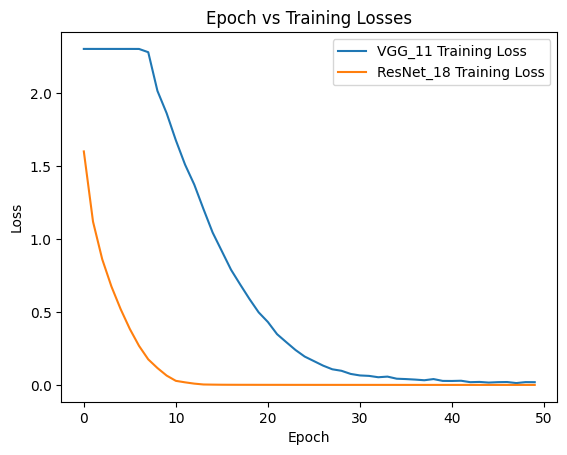

In [ ]:
# Plotting the training losses of both neural networks
plt.plot(VGG11_train_losses, label='VGG_11 Training Loss')
plt.plot(ResNet18_train_losses, label='ResNet_18 Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Training Losses')
plt.legend()
plt.xticks(range(0, num_epochs + 1, 10))
plt.show()